# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Задача

Построить модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

### План EDA 
Проведите исследовательский анализ данных:
- Посмотрите на размер выборки.
- Постройте график распределения возраста в выборке.
- Напечатайте на экране 10–15 фотографий и посмотрите, как устроен датасет.

Сделайте выводы о том, как результаты исследования повлияют на обучение модели.

### Описание данных

Данные взяты с сайта ChaLearn Looking at People.
https://chalearnlap.cvc.uab.cat/dataset/26/description/

Данные находятся в папке /datasets/faces/.

In [2]:
# импортируем необходимые бидлиотеки

import pandas as pd
import numpy as np

# keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

# визуализация
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")


In [3]:
# загрузка данных
labels = pd.read_csv('/datasets/faces/labels.csv')

# загрузка фотографий
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [4]:
labels.sample(10, random_state=42)

,file_name,real_age
800,000800.jpg,1
2644,002644.jpg,46
6521,006525.jpg,35
5572,005572.jpg,23
586,000586.jpg,47
996,000996.jpg,26
4472,004472.jpg,20
2944,002944.jpg,17
7386,007408.jpg,25
408,000408.jpg,27


In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Пропусков нет.

In [6]:
labels.describe().T

,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


Датасет смещен вправо, так как медиана возрастов больше среднего значения. Явных аномалий нет. Но было бы неплохо взглянуть на фото 100-летних.

**Вывод: Всего в распоряжении около 7600 объетов. Пропусков и явных аномалий нет.**

### Распределение по возрастам

#### Гистограммы

In [7]:
# количество корзин в гистограмме
cnt_bins = labels['real_age'].max() - labels['real_age'].min() 

''

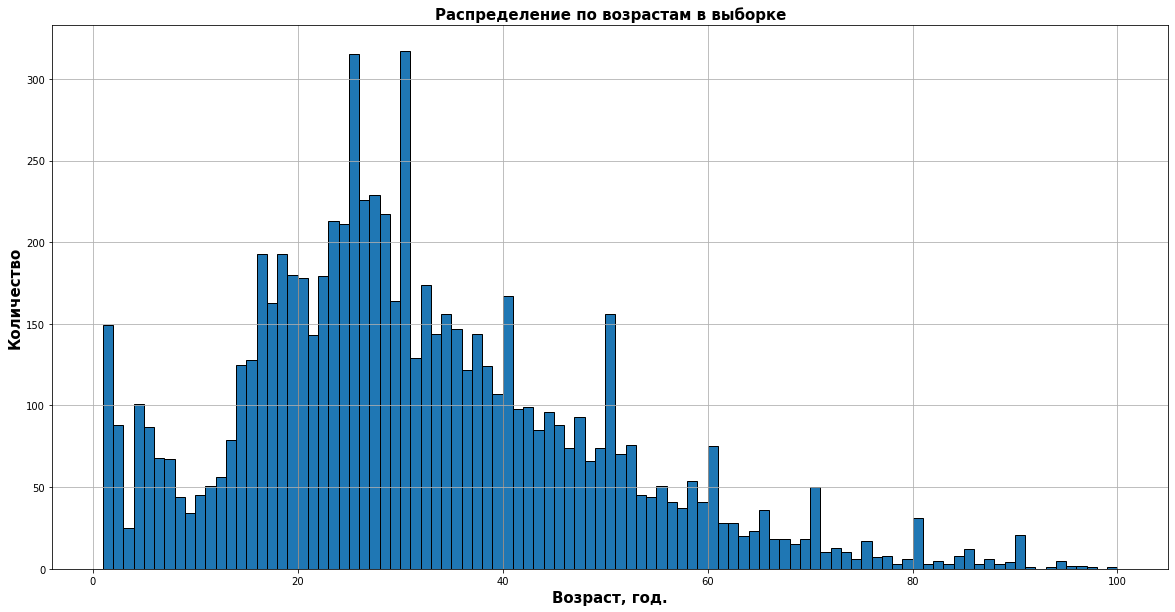

In [8]:
labels['real_age'].hist(bins=cnt_bins, ec='black', figsize=(20,10))
plt.xlabel('Возраст, год.', fontsize=15, weight = 'bold')
plt.ylabel('Количество', fontsize=15, weight = 'bold')
plt.title('Распределение по возрастам в выборке', fontsize=15, weight = 'bold')
;

Сглаженная функция плотности

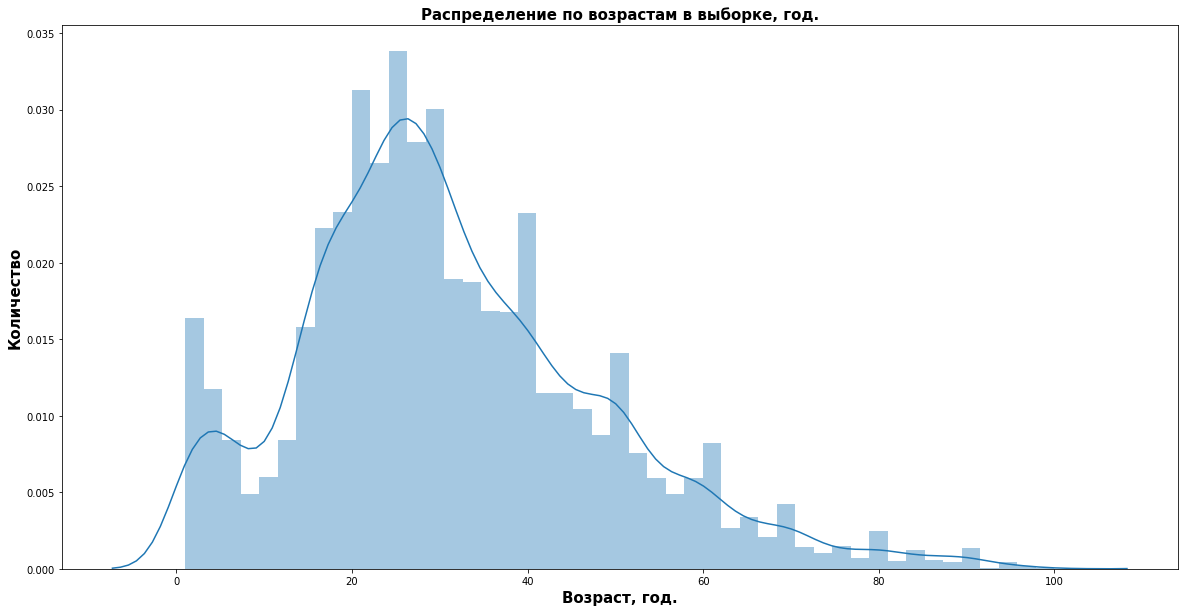

In [9]:
plt.figure(figsize=(20,10))
sns.distplot(labels['real_age']);
plt.xlabel('Возраст, год.', fontsize=15, weight = 'bold')
plt.ylabel('Количество', fontsize=15, weight = 'bold')
plt.title('Распределение по возрастам в выборке, год.', fontsize=15, weight = 'bold');

#### Ящик с усами.

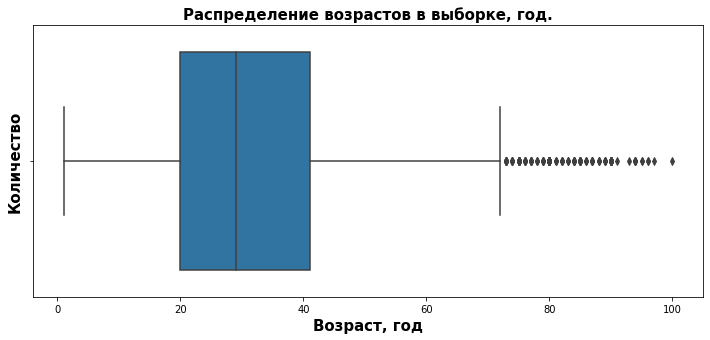

In [10]:
plt.figure(figsize=(12, 5))
ax = sns.boxplot(x=labels['real_age']);
plt.title("Распределение возрастов в выборке, год.",fontsize=15, weight = 'bold')
plt.ylabel('Количество',fontsize=15, weight = 'bold')
plt.xlabel('Возраст, год',fontsize=15, weight = 'bold');

По боксплоту видны выбросы в старшей возрастной группе, а также скошенность даьтасета.

**Вывод: Мы видим длинный хвост выбросов из возрастов больше 70 лет. Кроме того, есть несколько выбросов по средним возростам. в районе 25 - 30 лет. По-видимому, возраст указывался при разметке данных или при опросе приблизительно. Основная возрастная группа у нас это 20-40 лет, в этой группе ,по-видимому, мы будем хорошо определять возраст. А вот с контролем продажи алкоголя могут быть проблемы, так как в группе до 20 лет данных недостаточно.**

### Несколько фотографий из датасета

Получим первый батч из данных

In [11]:
features, target = next(train_gen_flow)

In [12]:
# Размерность батча
print(features.shape)
print(target.shape)

(32, 224, 224, 3)
(32,)


Всего в батче 32 объекта, 224Х224 пикселя в трех каналах RGB

In [13]:
# возраст
target

array([50, 41, 46, 85, 14, 40, 14, 53,  4, 32, 14, 23, 37, 62, 21, 58, 43,
       32, 25, 94, 30, 16, 23, 18, 41, 24, 26, 14, 36, 28, 78, 13])

Печатаем фото из первого батча

In [14]:
def print_batch():
    fig = plt.figure(figsize=(12,12))
    for i in range(32): # размер батча  = 32    
        fig.add_subplot(6, 6, i+1)
        plt.imshow(features[i])
        # для компактности удаляем оси и прижимаем изображения друг к другу
        plt.xticks([])
        plt.yticks([])
        plt.title('Возраст '+str(target[i]))
        plt.tight_layout()

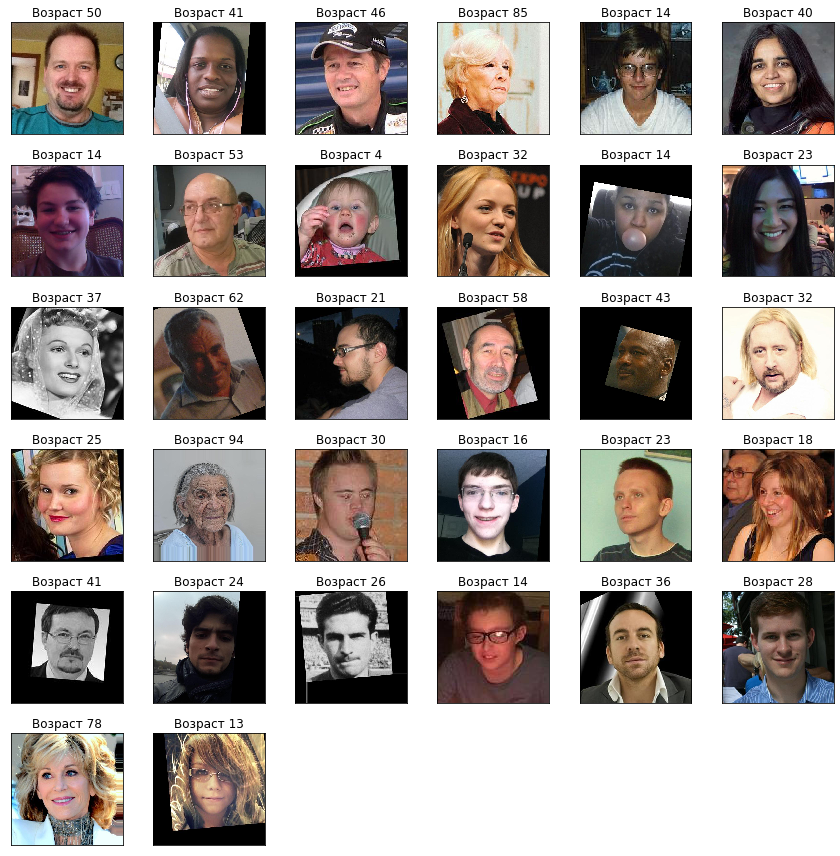

In [16]:
print_batch()

Получим оператором next второй батч, и также распечатаем его

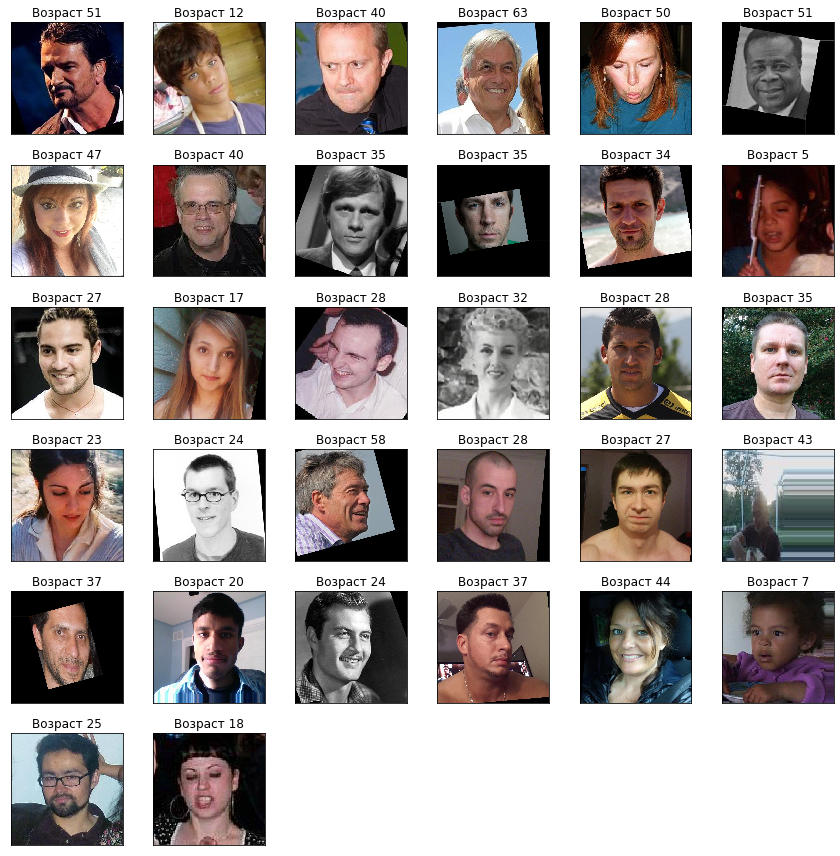

In [18]:
features, target = next(train_gen_flow)
print_batch()

**Вывод: На фотографиях представлены различные возрастные группы. Фотографии сняты в различных ракурсах, данных достаточно и аугментация не нужна. На некоторых фотографиях есть головные уборы и заполнен задний фон различными предметами. Возможно, это осложнит задачу.**

## Обучение модели

### Код

Обучение проводилось на Yandex Compute Cloud

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

# < Код для модели >
from tensorflow.keras.applications.resnet import ResNet50

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import pandas as pd

def load_train(path):

    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
                          validation_split=0.25,
                          rescale=1./255
                          )
    train_datagen_flow = (train_datagen.flow_from_dataframe(
                          dataframe=labels,
                          directory=path + 'final_files/',
                          x_col='file_name',
                          y_col='real_age',
                          target_size=(224, 224),
                          batch_size=16,
                          class_mode='raw',
                          subset='training',
                          seed=12345
                          )
    )

    return train_datagen_flow


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255 )

    test_datagen_flow = (test_datagen.flow_from_dataframe(
                          dataframe=labels,
                          directory=path + 'final_files/',
                          x_col='file_name',
                          y_col='real_age',
                          target_size=(224, 224),
                          batch_size=16,
                          class_mode='raw',
                          subset='validation',
                          seed=12345
                          )
    )

    return test_datagen_flow

def train_model(model, train_data, test_data, epochs=10, batch_size=None, steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=(test_data), epochs=epochs,
              steps_per_epoch=steps_per_epoch, batch_size=batch_size,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model

def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer=Adam(learning_rate=0.0005)

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

```

### Результат обучения модели

```

# < скопируйте результат вывода на экран сюда >
# < длинные строки со скачиванием модели можно удалить >

Train for 356 steps, validate for 119 steps
Epoch 1/10
2021-08-26 17:37:48.507069: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-08-26 17:37:49.096598: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 103s - loss: 208.6287 - mae: 11.0074 - val_loss: 394.8197 - val_mae: 14.8999
Epoch 2/10
356/356 - 37s - loss: 125.0866 - mae: 8.5496 - val_loss: 261.2041 - val_mae: 12.1673
Epoch 3/10
356/356 - 37s - loss: 91.0925 - mae: 7.3039 - val_loss: 132.9660 - val_mae: 8.9975
Epoch 4/10
356/356 - 37s - loss: 61.2085 - mae: 6.0738 - val_loss: 117.9015 - val_mae: 8.2050
Epoch 5/10
356/356 - 37s - loss: 41.6416 - mae: 4.9804 - val_loss: 118.2346 - val_mae: 8.2328
Epoch 6/10
356/356 - 37s - loss: 35.6960 - mae: 4.6688 - val_loss: 97.0774 - val_mae: 7.5246
Epoch 7/10
356/356 - 37s - loss: 25.2942 - mae: 3.9398 - val_loss: 114.8540 - val_mae: 8.5334
Epoch 8/10
356/356 - 37s - loss: 20.2654 - mae: 3.4562 - val_loss: 94.8573 - val_mae: 7.6687
Epoch 9/10
356/356 - 37s - loss: 17.4069 - mae: 3.2228 - val_loss: 83.2644 - val_mae: 6.8560
Epoch 10/10
356/356 - 37s - loss: 16.3742 - mae: 3.1202 - val_loss: 103.3696 - val_mae: 7.6009
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 9s - loss: 103.3696 - mae: 7.6009
Test MAE: 7.6009

```

## Анализ обученной модели

Была построена модель определения возраста человека. Использована технология ResNet50. Обучение проводилос в облаке Yandex Compute Cloud

На валидационной выборке удалось достичь метрики **MAE = 7.6009**.

- Было выполнено 10 эпох обучения. Метрика на тестовой выборке упала с 11.0074 до 3.1202, а на валидационной с 14.8999 до 7.6009. То есть, на тестовой выборке метрика улучшена в 4 раза тогда, как на валидационной выборке удалось улучшить метрику всего в два раза. Возможно, модель переобучена и надо было **ограничиться 9 эпохами обучения** со значением валидационной метрики **MAE = 6.8560**.

- Как и предполагалось из EDA ошибка при определении возраста для группы меньше 20 лет слишком велика. Контроль возраста при продаже алкоголя будет затруднен. Ошибка при определении верхней границы запрета продажи алкоголя может достигнуть 27 лет.

Для решения данной проблемы, возможно нужно расширить датасет объектами с возрастом до 20 лет.